## Imports

In [1]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import os 

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

## Plotting function

In [16]:
def plot_F1(F1, expcode, expcodes, save_path):
    for model, M_results in F1.items():
        x = []; y = []; z1 = []; z2 = []

    #     fig, axs = plt.subplots(1, 2, figsize = (13,5))
        fig = plt.figure(figsize = (13,6))    
        ax1 = fig.add_subplot(121, projection='3d'); ax2 = fig.add_subplot(122, projection='3d')

        for test_perc, T_results in M_results.items():
            perc = test_perc.split("=")[1]
            for item in T_results:
                x.append(float(perc)); y.append(item['num_epochs']);z1.append(item['avg_f1'][0]); z2.append(item['avg_f1'][1])
        
        fig.suptitle(expcodes[expcode]+ "_" + model, fontsize=16)
        ax1.set_zlim(0, 1); ax2.set_zlim(0, 1)
        ax1.set_xlabel('test_perc'); ax2.set_xlabel('test_perc')
        ax1.set_ylabel('num_epochs'); ax2.set_ylabel('num_epochs')
        ax1.set_zlabel('F1'); ax2.set_zlabel('F1')
        ax1.set_title('Avg Macro'); ax2.set_title('Avg Weighted')
        fig.subplots_adjust(wspace=0.5)
        ax1.scatter3D(np.array(x), np.array(y), np.array(z1), c=np.array(z1), cmap='viridis')
        ax2.scatter3D(np.array(x), np.array(y), np.array(z2), c=np.array(z2), cmap='viridis')
        
        plt.savefig(f"{save_path}/{expcodes[expcode]}_{model}")
        plt.show()
        
def select_best_scores(dictionary):
    results_list = []
    for key, value in dictionary.items():
        for model, T_results in value.items():
            for item in T_results:
#                 print(model," -- ", key," -- ",item['num_epochs']," -- ",item['avg_f1'][0])
                results_list.append([model, key, item['num_epochs'], item['avg_f1'][0]])
    results_list.sort(key=lambda x:x[3], reverse = True)
    print(results_list[0:3])
    
    
        

def transform_data(dictionary):
    new_dict = {}
    for key, value in dictionary.items():
        for model, T_results in value.items():
            if model in new_dict:
                new_dict[model][key] = T_results
            else:
                new_dict[model] = {}
                new_dict[model][key] = T_results
            
    return new_dict
    
  

## Data loading

Temporary requirement: Put all the EXPi folders in a single folder called `F1_multiclass_results` in the `input` folder.

**Note:** Jordi, I know you used `Path` but for some reason I was not able to retrieve all the json files using that method, so I added an alternative.

../input/F1_multiclass_results/EXP10_FineTuningResults.json
../input/F1_multiclass_results/EXP11_FineTuningResults.json
../input/F1_multiclass_results/EXP12_FineTuningResults.json
../input/F1_multiclass_results/EXP13_FineTuningResults.json
../input/F1_multiclass_results/EXP14_FineTuningResults.json
../input/F1_multiclass_results/EXP15_FineTuningResults.json
../input/F1_multiclass_results/EXP20_FineTuningResults.json
[['stsb-xlm-r-multilingual', 'test_perc=0.2', 10, 0.7036415289256198], ['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.15', 4, 0.68125], ['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.15', 6, 0.6212111073937772]]


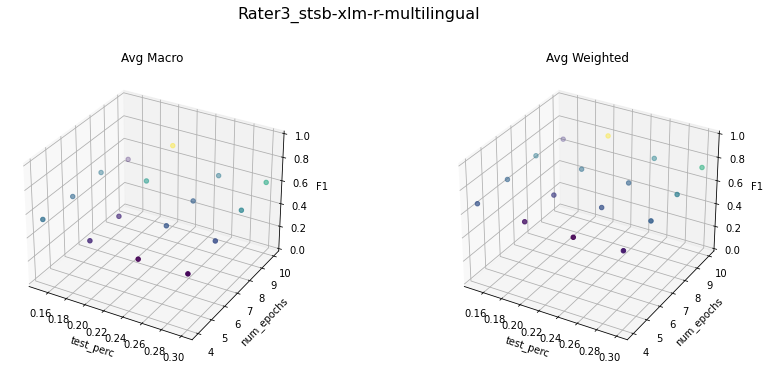

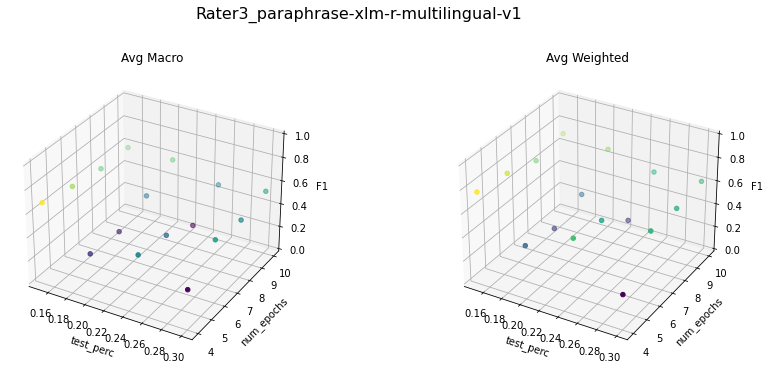

../input/F1_multiclass_results/EXP21_FineTuningResults.json
[['stsb-xlm-r-multilingual', 'test_perc=0.15', 6, 0.8333801463522803], ['stsb-xlm-r-multilingual', 'test_perc=0.2', 10, 0.8198896011396011], ['stsb-xlm-r-multilingual', 'test_perc=0.15', 8, 0.8057795698924731]]


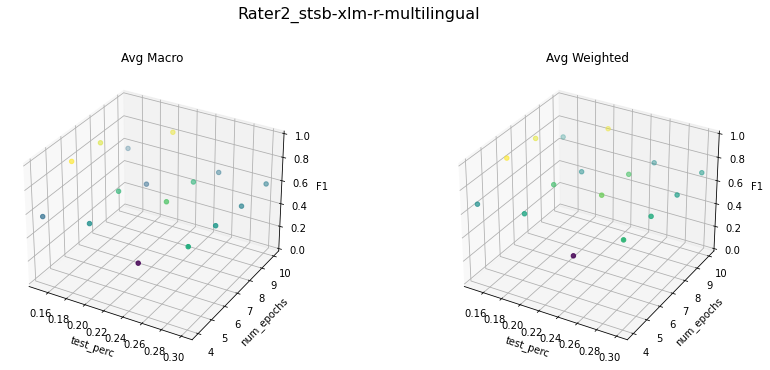

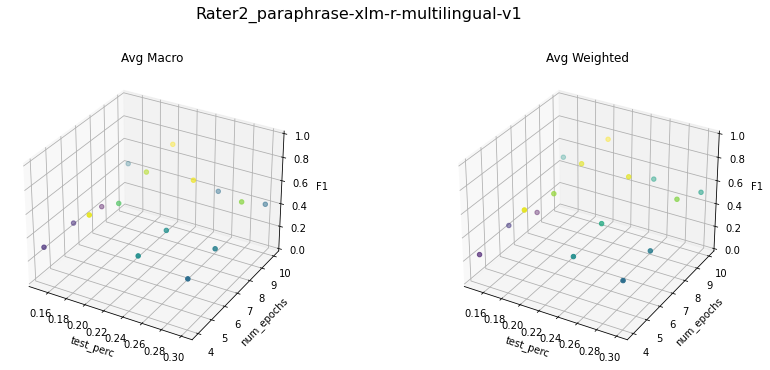

../input/F1_multiclass_results/EXP22_FineTuningResults.json
[['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.25', 8, 0.7074812030075188], ['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.15', 8, 0.6948920212078107], ['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.2', 8, 0.6830808080808082]]


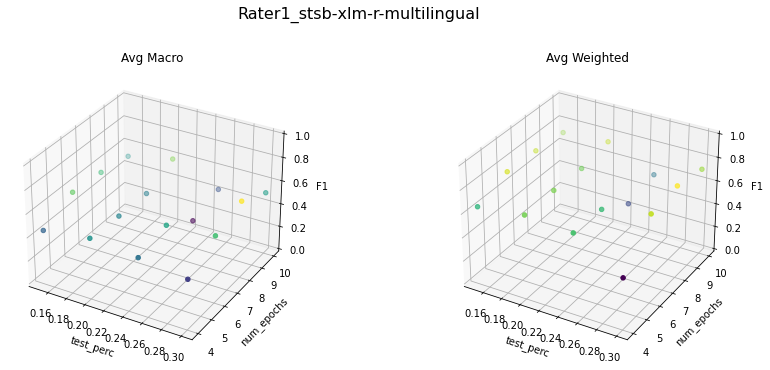

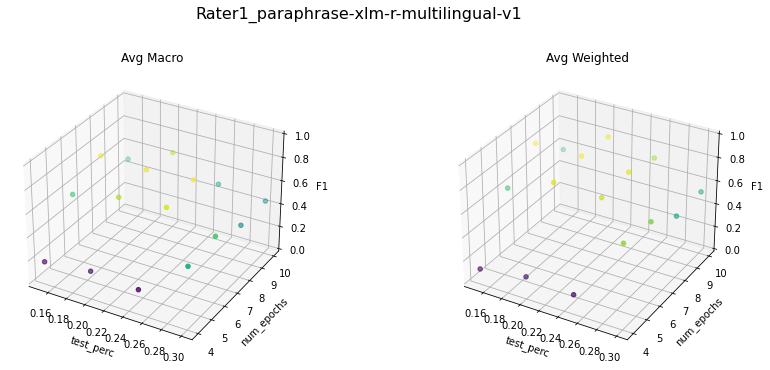

In [19]:
# path = Path("C:/Users/user/Google Drive/Els_meus_documents/projectes/CompetitiveIntelligence/WRI/Notebooks/Data/finetuningResults")
# filename = "FineTuningResults.json"

# sub_path = Path("C:/Users/user/Google Drive/Els_meus_documents/projectes/CompetitiveIntelligence/WRI/Notebooks/Data/finetuningResults/")
# paths = sub_path.glob('*.json')


models = ["stsb-xlm-r", "paraphrase-xlm-r"]#"distiluse-base", "quora-distilbert", 

exp_codes = {'10' : "Rater3 all labels but unknown",
            '11' : "Rater2 all labels but unknown",
            '12' : "Rater1 all labels but unknown",
            '13' : "Rater3 all labels",
            '14' : "Rater2 all labels",
            '15' : "Rater1 all labels"}

exp_codes = {'20' : "Rater3",
            '21' : "Rater2",
            '22' : "Rater1"}

results_path = "../input/F1_multiclass_results/"
output_path = "../output/"
all_files = [os.path.join(root, file) for root, dirs, files in os.walk(results_path) for file in files]
exp_results_json = [file for file in all_files if file.endswith(".json")]

for exp_result in exp_results_json:
    print(exp_result)
    exp_number = exp_result.split("EXP")[1].split("_")[0]
    if int(exp_number) > 19:
        with open(exp_result, "r") as f:
            F1 = json.load(f)
        select_best_scores(F1)
        plot_F1(transform_data(F1), exp_number, exp_codes, output_path)

# for path in paths:
#     # because path is object not string
#     path_in_str = str(path)
#     exp_number = path_in_str.split("EXP")[1].split("_")[0]
#     print(exp_number)
#     print(path_in_str)
#     if int(exp_number) > 9:
#         with open(path_in_str, "r") as f:
#             F1 = json.load(f)
#         plot_F1(transform_data(F1), exp_number, exp_codes, sub_path)